In [1]:
###### HI HELLO
import numpy as np # fast array library
import pandas as pd # data frames library
from pandas_ods_reader import read_ods #read ods tables

import matplotlib 
import matplotlib.pyplot as plt # plot library
import matplotlib.gridspec as gridspec
 
import subprocess # these 2 lines below load OS functionality
import sys
import json
import warnings

from IPython.display import display, HTML # screen on display in HTML library 

import sympy as sp # symbolic calculation library functions
from sympy import var # symbolic calculation library variables

import mpmath as mp # double (or higher) floating point precision library (not used)

import scipy.constants as ct # import mathematical constants
import scipy.special as spec
from scipy.spatial import Voronoi, voronoi_plot_2d # import Voronoi functions
import scipy.optimize as optimize # optimazation library (not used)
from scipy import signal # noise filtering functions
from scipy import stats # statistics, for binning and fields calculation
from scipy.fft import fft, ifft, fftfreq

from scipy.spatial import Voronoi, voronoi_plot_2d # import Voronoi functions


import ipywidgets as widgets # import 

import time # timing functions (for computation time)
from pytictoc import TicToc

# print progress function
# more elegant (python 3 alternative): print('\rhello', end='',flush=True)
def printp(string):
    sys.stdout.write('\r'+ str(string))
    sys.stdout.flush()
    
#from __future__ import print_function

# Text format for figures configuration (lines below)
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size': 16})
#rc('font',**{'family':'serif','serif':['Times']})
#rc('text', usetex=True)

In [2]:
%matplotlib ipympl

(-1.0, 1.0)

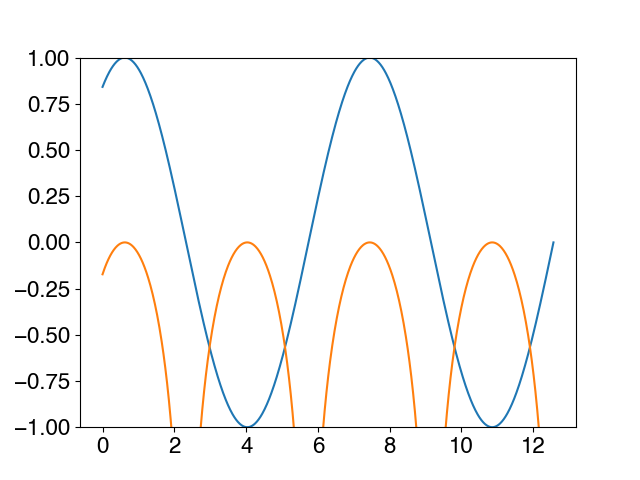

In [3]:
plt.figure(0)
plt.plot(np.linspace(0,4*np.pi,1000), np.sin(np.linspace(1,4*np.pi,1000)))
plt.plot(np.linspace(0,4*np.pi,1000), np.log(np.abs(np.sin(np.linspace(1,4*np.pi,1000)))) )
plt.ylim(-1,1)

In [4]:
plt.close(0)

## _Read tracking data_ 

We explain the action of each of these functions below:

__get_info(series_directory, hash_prefix, silent) :__ Reads and prints info file with  _hash prefix_ hash code. See output table in <font color='red' >RUN CELL 0</font> below to grasp the info structure

__simple_pickle_read(series_directory, hash_prefix) :__
This 'simple_pickle_read' takes a pkl.xz file _hash prefix_ hash code, and which contains xy positions and tracks (no velocities) and stores in 'tabla' pandas data frame.
   
  * input: hash_prefix
  * output: global variable _Ntracks_ (number of tracks) 

In [5]:
def pdisplay(info):
    display(HTML(info.to_html()))

# This function reads pickle binary file (.pkl) with trajectories
def get_info(series_directory, hash_prefix, silent):
    global info
    nombre = '/home/fvega/Datos/blades/packing_fraction_0' + series_directory + '/info/'  + hash_prefix + '.txt'
    with open(nombre) as f:
        jsonstr = json.load(f)
    info = pd.json_normalize(jsonstr)
    if silent==False:
        pdisplay(info.T)
    return info
    
def simple_pickle_read(series_directory, hash_prefix):
    global Nframes, Ntracks
    # Read table in pickle format
    nombre = '/home/fvega/Datos/blades/packing_fraction_0' + series_directory + '/tracks/ref_angle/' +  hash_prefix \
       + '.pkl.xz'
    tabla = pd.read_pickle(nombre, compression='infer')
    tabla = tabla.reset_index(drop=True) # por si los indices salen desordenados
    Nframes = np.max(tabla.frame)
    Ntracks = np.max(tabla.track)+1
    tabla = tabla.sort_values(by = ['frame', 'track']).reset_index(drop=True)
    return tabla


In [7]:
experiments = read_ods('/home/fvega/Datos/blades/tabla_experimentos.ods', sheet=0)
experiments = experiments[['ID', 'N', 'fps','Tt', 'w']][:115]

In [8]:
experiments.head(10)

,ID,N,fps,Tt,w
0,1d75395066f40a6c318e39b0ea365671,3.0,250.0,0.079087,-0.790982
1,e256014353100ffaf5699f8373be9404,3.0,900.0,0.079087,-0.790982
2,707199705ed58a387dcdf897521e69ea,3.0,250.0,0.153720,-1.227455
3,a7720cc40224188bc328d4f419fb5e37,3.0,900.0,0.153720,-1.227455
4,0aa85dade5cb0a2299522f33aa4d36b2,3.0,250.0,0.456796,-0.662063
5,bff936348d62873d1da3be692fa4afd3,3.0,900.0,0.456796,-0.662063
6,cc5aad54bc3e5a54ff8c7992e478662c,3.0,250.0,0.598469,-0.655598
7,834487b1e96c80d7728c2a35949d44b2,3.0,900.0,0.598469,-0.655598
8,30ee47e3544c2446e93fd42cdb1c7902,3.0,250.0,0.791003,-0.596617
9,aba9c12a0c8b3439a7f3b461d9a3d1e2,3.0,900.0,0.791003,-0.596617


In [9]:
exp45 = experiments[experiments.N==45]
exp45[exp45.fps==900]

,ID,N,fps,Tt,w
62,9bd37c11859b49f916d355e03d62a6fc,45.0,900.0,0.455877,-0.387854
71,88b7a67af600a40edfc04b8a2487a511,45.0,900.0,1.775451,0.221584
74,712d5be2fce52eade6c5564a1f80368f,45.0,900.0,2.646642,0.516204
76,0ac3fe44813e723638d804572aa69d8d,45.0,900.0,3.188665,0.729849
78,34913bb5677f08882949585aabd7ee16,45.0,900.0,3.253042,0.760220


In [10]:
tabla = simple_pickle_read( '45', '712d5be2fce52eade6c5564a1f80368f_w')

In [11]:
tabla.head()

,frame,track,x,y,r,vx,vy,theta,w
0,1,0,40.447408,-328.000325,330.503922,0.524411,-0.130805,0.054788,-0.257425
1,1,1,250.116228,46.946393,254.483786,0.081716,0.258624,0.124128,-0.306061
2,1,2,148.381647,46.766712,155.597506,-0.524196,-0.366213,0.028424,-0.259548
3,1,3,-101.934270,61.259356,118.969281,0.188688,0.546385,0.843234,-0.256986
4,1,4,-22.228572,72.072925,75.432304,-0.097197,-0.233317,0.078081,-0.228640


In [12]:
info = get_info('45', '712d5be2fce52eade6c5564a1f80368f', False)

,0
experiment_id,712d5be2fce52eade6c5564a1f80368f
original_file,/mnt/beegfs/malopez/serieAspas/serieAspas_N45_p23_fps900_1.cine
date,2038-01-19 06:37:38
shape,"[1280, 800]"
fps,900
exposure,1109
n_frames,24981
recording_time,27.756667
camera_distance,0.95
pixel_ratio,1075.862069


In [13]:
info.fps[0]

900

In [14]:
def time_shift_mat_av(array, it):
    nt = len(array)
    return np.sum( np.diag(array , k=it)[:nt,:nt].dot(array) )/(nt-i-1)

def time_shift_np_av(array, denom,it):
    return np.mean(array[:-it] * array[it:])/denom

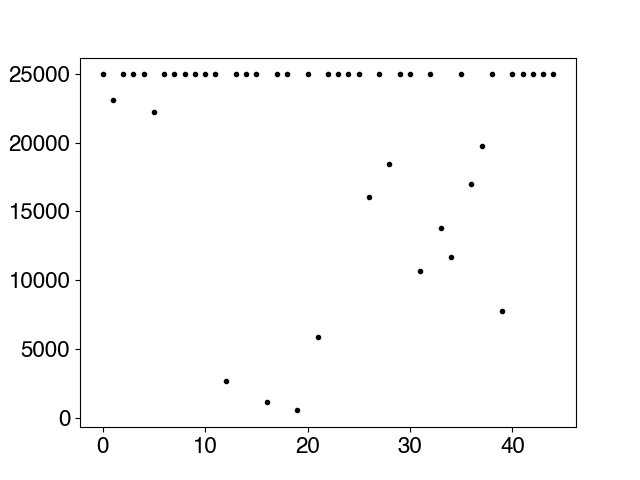

In [15]:
lengths = np.array([ len(tabla[tabla.track==i]) for i in range(45)])
nt = np.max(lengths)
parts=np.where( lengths>nt)[0]

plt.figure(1)
plt.plot(lengths, '.', c='k')


In [16]:
plt.close(1)

In [17]:
lengths = np.array([ len(tabla[tabla.track==i]) for i in range(45)])

#nt = np.max(lengths)
nt = 20000
parts = np.where(lengths >= nt)[0]
nparts = len(parts)

t = np.array( [ i/info.fps[0] for i in range(nt) ] )
Awpt = np.zeros((nparts,nt))

#w = tabla.w.values
#wav = np.mean(w)
#W = w - wav

#A0 = np.mean(W*W)

for j in range(nparts):
    w = tabla[tabla.track==parts[j]].w.values[:nt] 
    wav = np.mean(w)
    W = w - wav
    #A0 = np.mean( W*W )    
    for i in range(1, nt-1):
        Awpt[j,i] = time_shift_np_av(W, 1, i)
        if i%1000==0:
            printp(str(i) + ' for particle ' + str(j+1) + ' out of ' + str(nparts) + ' particles' )

Awt = np.mean(Awpt, axis=0)

19000 for particle 33 out of 33 particles

In [18]:
lengths = np.array([ len(tabla[tabla.track==i]) for i in range(45)])

#nt = np.max(lengths)
nt = 20000
parts = np.where(lengths >= nt)[0]

t = np.array( [ i/info.fps[0] for i in range(nt) ] )
Apt = np.zeros((nparts,nt))

vx = tabla.vx.values
#vy = tabla.vy.values
A0 = np.mean(vx*vx)

nparts = len(parts)

for j in range(nparts):
    vx = tabla[tabla.track==parts[j]].vx.values[:nt]  
    for i in range(1, nt-1):
        Apt[j,i] = time_shift_np_av(vx, A0, i)
        if i%1000==0:
            printp(str(i) + ' for particle ' + str(j+1) + ' out of ' + str(nparts) + ' particles' )

Avt = np.mean(Apt, axis=0)

19000 for particle 33 out of 33 particles

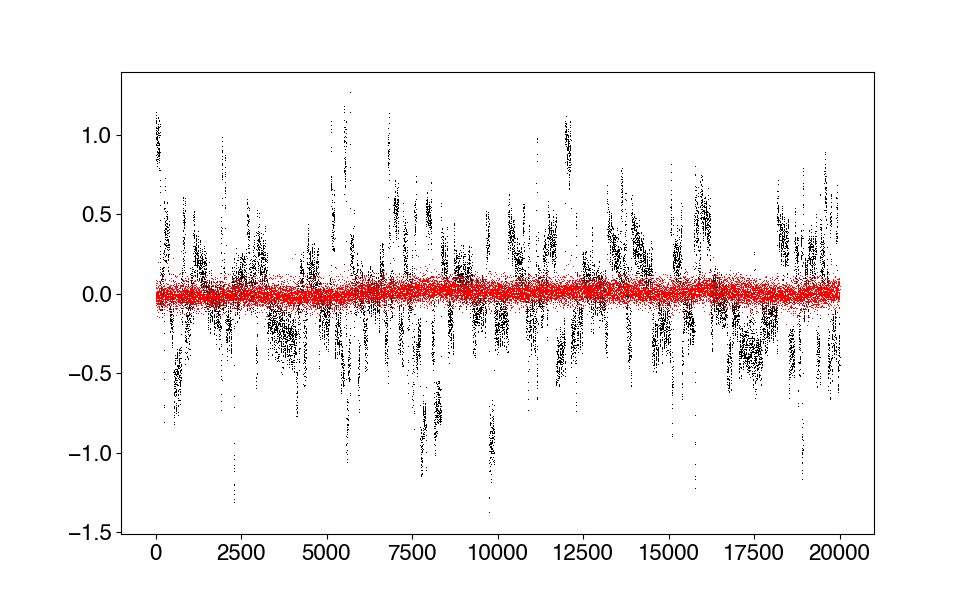

In [19]:
plt.figure(2, figsize=(6*ct.golden_ratio,6))
plt.plot(vx,',',c='k')
plt.plot(W,',', c='r')

In [20]:
plt.close(2)

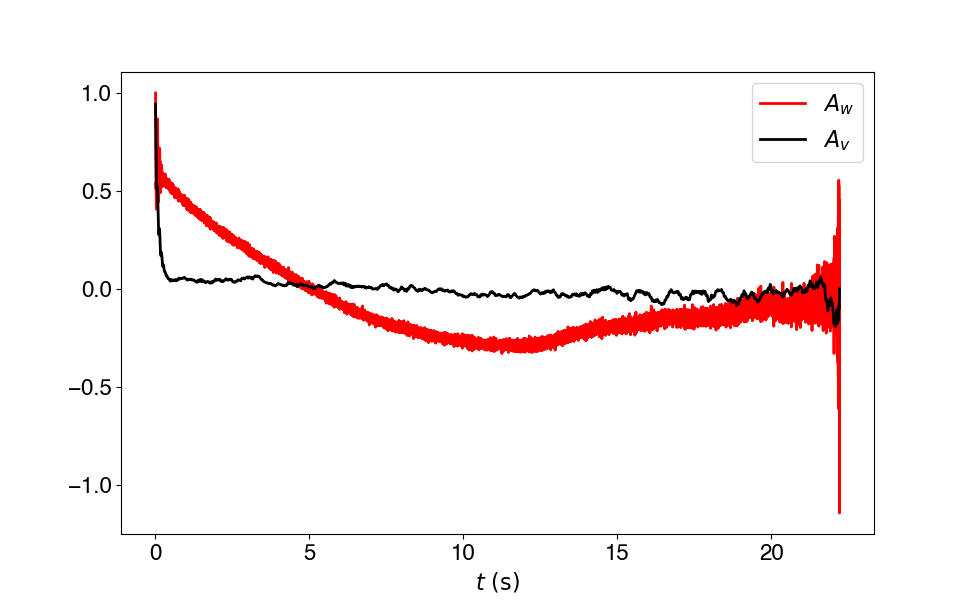

In [21]:
plt.figure(3,figsize=(6*ct.golden_ratio,6))
plt.xlabel(r'$t~\mathrm{(s)}$')
plt.plot(t[2:],Awt[2:]/Awt[2],c ='r', lw=2)
plt.plot(t[2:],Avt[2:], c='k', lw =2)
plt.legend([r'$A_w$', r'$A_v$'])

In [22]:
plt.close(3)

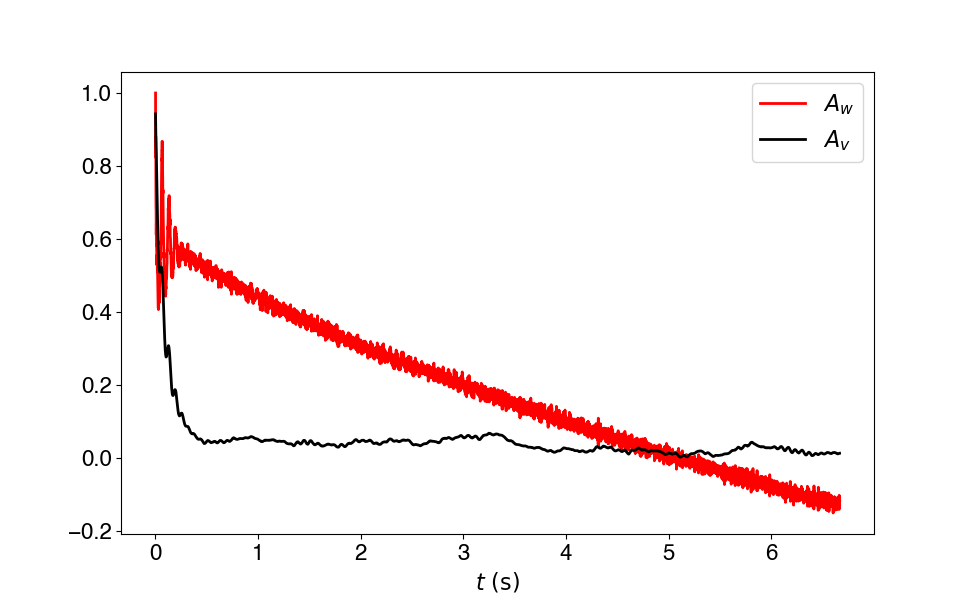

In [23]:
plt.figure(4,figsize=(6*ct.golden_ratio,6))
plt.xlabel(r'$t~\mathrm{(s)}$')
plt.plot(t[2:6000],Awt[2:6000]/Awt[2],c ='r', lw=2)
plt.plot(t[2:6000],Avt[2:6000], c='k', lw =2)
plt.legend([r'$A_w$', r'$A_v$'])


In [24]:
plt.close(4)

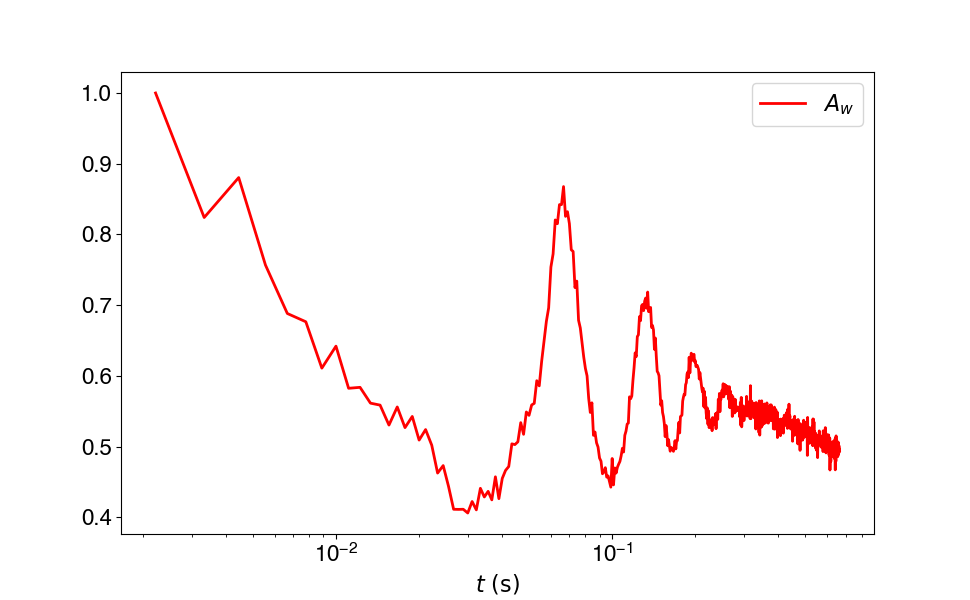

In [61]:
plt.figure(5,figsize=(6*ct.golden_ratio,6))
plt.xlabel(r'$t~\mathrm{(s)}$')
plt.xscale('log')
plt.plot(t[2:600],Awt[2:600]/Awt[2],c ='r', lw=2)
#plt.plot(t[2:600],Avt[2:600], c='k', lw =2)
plt.legend([r'$A_w$', r'$A_v$'])

In [60]:
plt.close(5)

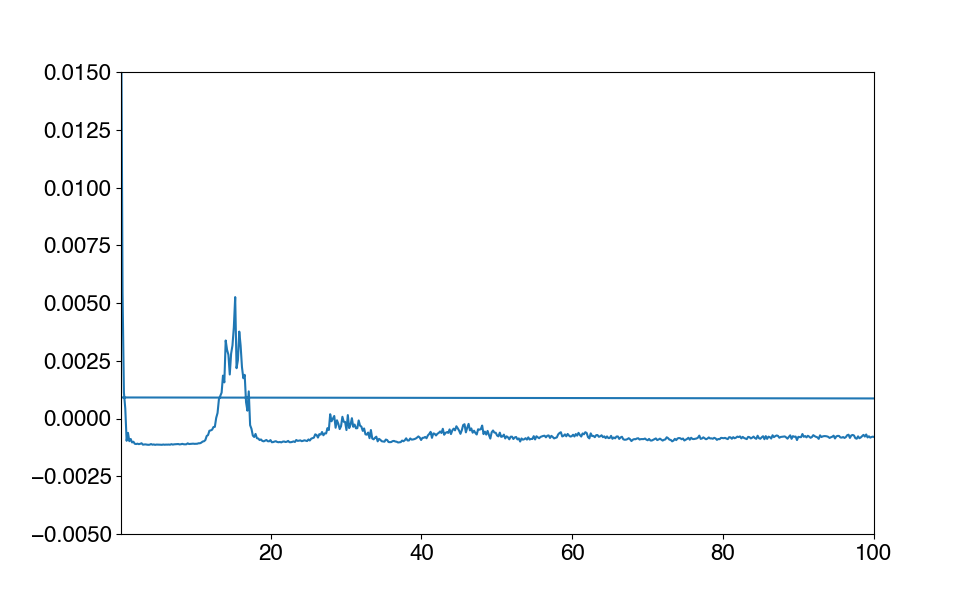

In [42]:
plt.figure(6, figsize=(6*ct.golden_ratio, 6))
plt.xlim(0.2,100)
plt.ylim(-0.005, 0.015)
plt.plot( fftfreq(5000,d=1/info.fps[0]), np.real(fft(Awt[:5000])) )

In [32]:
plt.close(6)


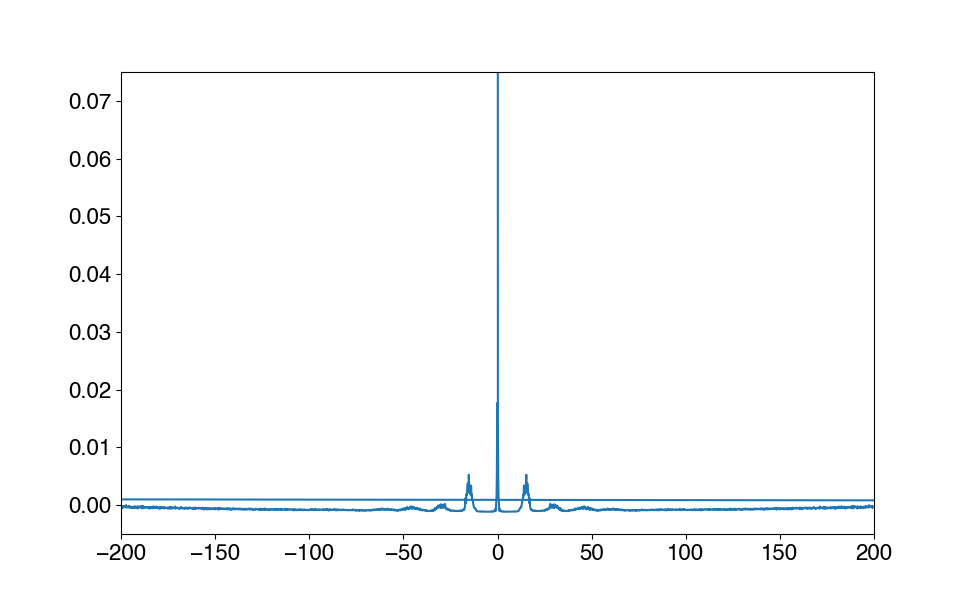

In [33]:
plt.figure(7, figsize=(6*ct.golden_ratio, 6))
plt.xlim(-200,200)
plt.ylim(-0.005, 0.075)

plt.plot( fftfreq(5000,d=1/info.fps[0]), np.real(fft(Awt[:5000] )) )

In [34]:
plt.close(7)

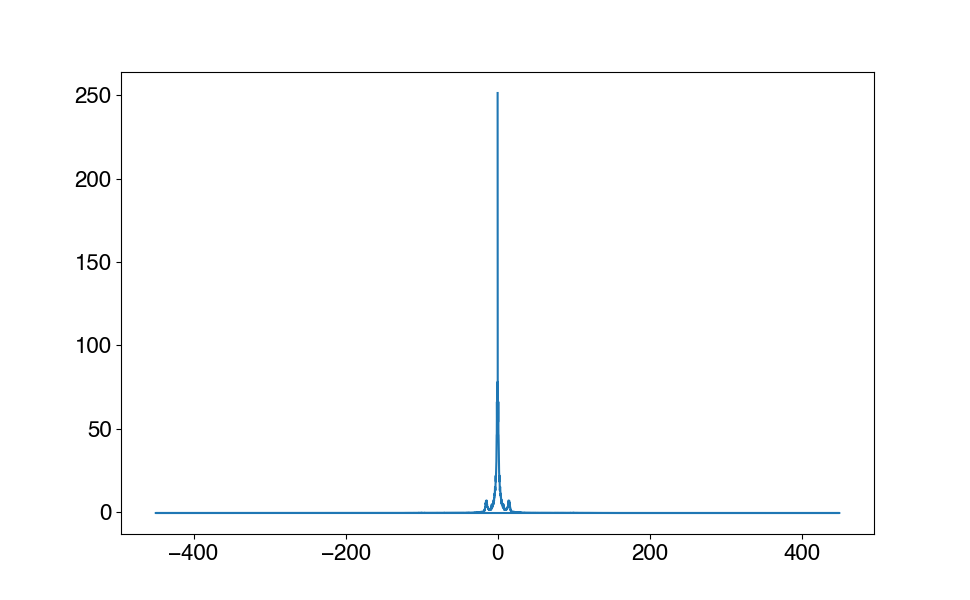

In [41]:
plt.figure(8, figsize=(6*ct.golden_ratio, 6))
#plt.xlim(0.2,100)
#plt.ylim(-0.005, 0.015)
plt.plot( fftfreq(5000,d=1/info.fps[0]), np.real(fft(Avt[:5000])) )

In [40]:
plt.close(8)

## Frecuencias características, $N=45$

In [35]:
frecs45 = np.array( [ [0.456, 10.26], [1.775, 13.51], [2.647, 15.29], [3.25, 17.10] ] )

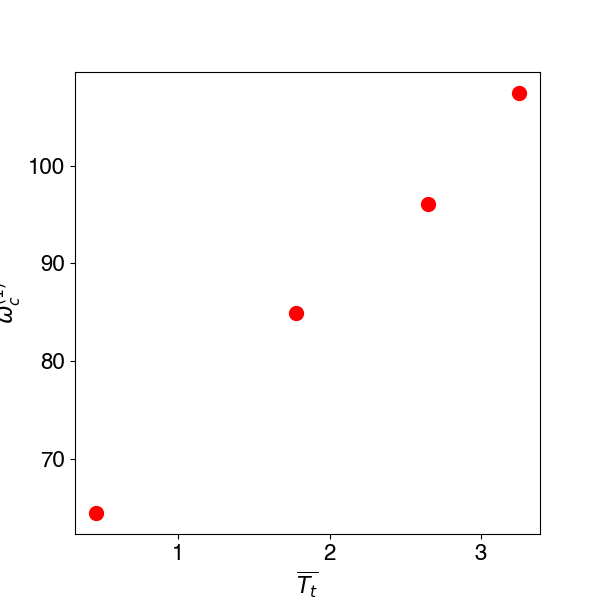

In [51]:
plt.figure(9, figsize =(6, 6))
plt.xlabel( r'$\overline{T_t}$' )
plt.ylabel( r'$\omega_c^{(1)}$' )
plt.plot(frecs45.T[0], frecs45.T[1] * 2*np.pi, '.', c='r', ms=20 )

In [50]:
plt.close(9)